In [17]:
#importing libraies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
%matplotlib inline
# Reset TF and random seed (for reproducible results).
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# Input data files are available in the "../input/" directory.
from subprocess import check_output
print(check_output(["ls", "us_perm_visas.csv"]).decode("utf8"))

us_perm_visas.csv



In [18]:
# Exploratory of Datasets

df = pd.read_csv('us_perm_visas.csv', low_memory = False, parse_dates=['decision_date', 'case_received_date'])

In [19]:
# Displaying number of rows and columns
print('Number of Visa Applications:', len(df))
print('Number of Columns:', len(df.columns))

Number of Visa Applications: 374362
Number of Columns: 154


In [20]:
# Displaying 5 first rows and last 5 rows
print("The first 5 rows:", df.head())
print("The last 5 rows:", df.tail())

The first 5 rows:   add_these_pw_job_title_9089 agent_city agent_firm_name agent_state  \
0                         NaN        NaN             NaN         NaN   
1                         NaN        NaN             NaN         NaN   
2                         NaN        NaN             NaN         NaN   
3                         NaN        NaN             NaN         NaN   
4                         NaN        NaN             NaN         NaN   

  application_type        case_no case_number case_received_date case_status  \
0             PERM  A-07323-97014         NaN                NaT   Certified   
1             PERM  A-07332-99439         NaN                NaT      Denied   
2             PERM  A-07333-99643         NaN                NaT   Certified   
3             PERM  A-07339-01930         NaN                NaT   Certified   
4             PERM  A-07345-03565         NaN                NaT   Certified   

  class_of_admission  ... ri_pvt_employment_firm_to ri_us_workers_co

In [21]:
#display attributes in the dataset.
print(df.columns.values)

['add_these_pw_job_title_9089' 'agent_city' 'agent_firm_name'
 'agent_state' 'application_type' 'case_no' 'case_number'
 'case_received_date' 'case_status' 'class_of_admission'
 'country_of_citizenship' 'country_of_citzenship' 'decision_date'
 'employer_address_1' 'employer_address_2' 'employer_city'
 'employer_country' 'employer_decl_info_title' 'employer_name'
 'employer_num_employees' 'employer_phone' 'employer_phone_ext'
 'employer_postal_code' 'employer_state' 'employer_yr_estab'
 'foreign_worker_info_alt_edu_experience'
 'foreign_worker_info_birth_country' 'foreign_worker_info_city'
 'foreign_worker_info_education' 'foreign_worker_info_education_other'
 'foreign_worker_info_inst' 'foreign_worker_info_major'
 'foreign_worker_info_postal_code' 'foreign_worker_info_rel_occup_exp'
 'foreign_worker_info_req_experience' 'foreign_worker_info_state'
 'foreign_worker_info_training_comp' 'foreign_worker_ownership_interest'
 'foreign_worker_yr_rel_edu_completed' 'fw_info_alt_edu_experience'

In [22]:
# Checking length of case_number and case_no

print("Length of 'case_number' column is: ", len(df['case_number'])," with",df.case_number.isnull().sum(), "missing values")
print("Length of 'case_no' column is: ", len(df['case_no'])," with", df.case_no.isnull().sum(),"missing values \n")

print("First 2 values of case_number column are : \n", df['case_number'].head(2),"\n")

print("Last 2 values of case_number column are : \n", df['case_number'].tail(2), "\n")
print("First 2 values of case_no column are : \n", df['case_no'].head(2), "\n")
print("Last 2 values of case_no column are : \n", df['case_no'].tail(2))

Length of 'case_number' column is:  374362  with 135269 missing values
Length of 'case_no' column is:  374362  with 239093 missing values 

First 2 values of case_number column are : 
 0    NaN
1    NaN
Name: case_number, dtype: object 

Last 2 values of case_number column are : 
 374360    A-16357-84250
374361    A-16279-59292
Name: case_number, dtype: object 

First 2 values of case_no column are : 
 0    A-07323-97014
1    A-07332-99439
Name: case_no, dtype: object 

Last 2 values of case_no column are : 
 374360    NaN
374361    NaN
Name: case_no, dtype: object


In [23]:
# Creating new columns containing non missing values from both "case_number" and "case_no"

casenoindex = df.columns.get_loc("case_no")
casenumberindex = df.columns.get_loc("case_number")
casenumberlist = []

for value in df.iloc[0:135269,casenoindex]:
    casenumberlist.append(value)
    
for value in df.iloc[135269:374363,casenumberindex]:
    casenumberlist.append(value)
    
df['casenumber'] = casenumberlist
df.drop(df.columns[[casenoindex,casenumberindex]], axis=1, inplace=True)

In [24]:
#Printing number of unique values for 'case_status' column

for value in df.case_status.unique():
    print(len(df[df['case_status'] == value])," occurrences of status '{}'".format(value))

181933  occurrences of status 'Certified'
25649  occurrences of status 'Denied'
148586  occurrences of status 'Certified-Expired'
18194  occurrences of status 'Withdrawn'


In [25]:
#Removing all withdrawn applications
df = df[df.case_status != 'Withdrawn']

#Combining certified-expired and certified applications and displaying distribution of "case_status" variable
df.loc[df.case_status == 'Certified-Expired', 'case_status'] = 'Certified'
df.case_status.value_counts()

case_status
Certified    330519
Denied        25649
Name: count, dtype: int64

In [26]:
# Percentage of case_status.

df['case_status'].value_counts()/len(df)*100

case_status
Certified    92.798623
Denied        7.201377
Name: count, dtype: float64

In [27]:
#Dropping all empty columns
df = df.dropna(axis=1, how='all');

#Dropping all empty rows
df = df.dropna(axis=0, how='all');

df.shape

(356168, 153)

In [28]:
# Displaying number of missing values in each column
for column in df.columns:
    print("Attribute '{}' contains ".format(column),  df[column].isnull().sum().sum(), " missing values")

Attribute 'add_these_pw_job_title_9089' contains  317031  missing values
Attribute 'agent_city' contains  153452  missing values
Attribute 'agent_firm_name' contains  157646  missing values
Attribute 'agent_state' contains  156544  missing values
Attribute 'application_type' contains  229320  missing values
Attribute 'case_received_date' contains  126848  missing values
Attribute 'case_status' contains  0  missing values
Attribute 'class_of_admission' contains  21085  missing values
Attribute 'country_of_citizenship' contains  19272  missing values
Attribute 'country_of_citzenship' contains  336951  missing values
Attribute 'decision_date' contains  0  missing values
Attribute 'employer_address_1' contains  37  missing values
Attribute 'employer_address_2' contains  236133  missing values
Attribute 'employer_city' contains  10  missing values
Attribute 'employer_country' contains  126920  missing values
Attribute 'employer_decl_info_title' contains  126886  missing values
Attribute 'em

[Text(0.5, 0, 'Visa application year'),
 Text(0, 0.5, 'Number of Visa applicatons')]

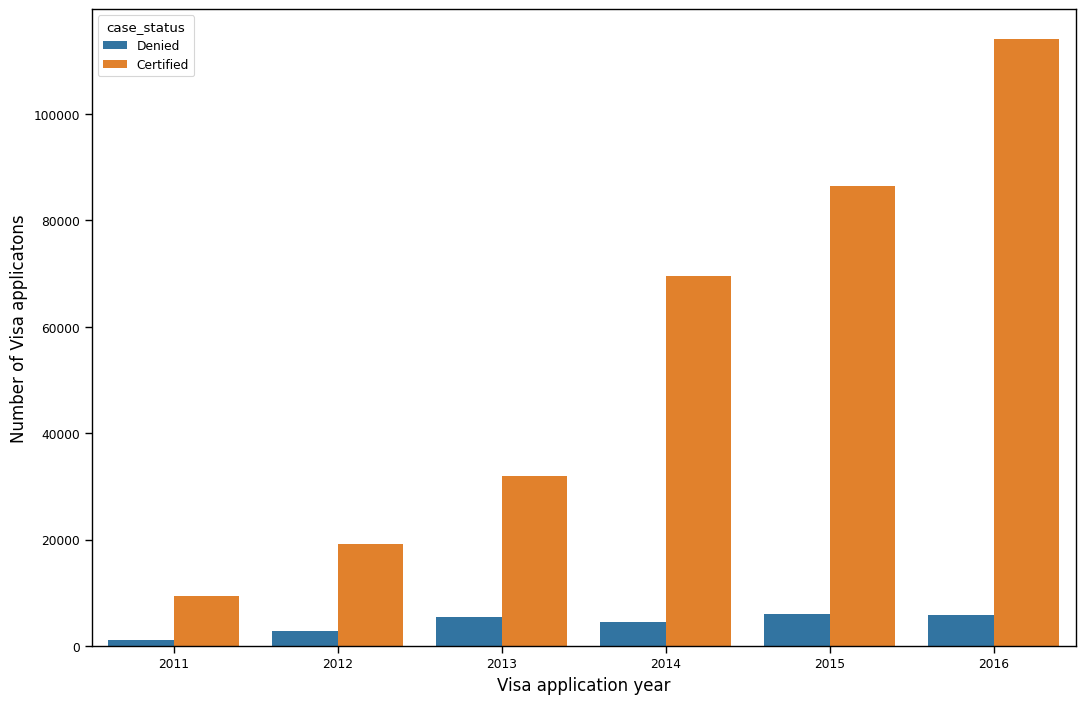

In [29]:
#Converting the date to contain just the year of application submission
df['year'] = df['decision_date'].dt.year

#Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)
sns.set_context(rc={"font.size":12})
sns.countplot(x="year", hue="case_status", data=df)
ax.set(xlabel='Visa application year', ylabel='Number of Visa applicatons')

In [30]:
# Displaying 15 most popular cities
df['employer_city'] = df['employer_city'].str.upper()
df['employer_city'].value_counts().head(15)

employer_city
NEW YORK           17198
COLLEGE STATION    11985
SANTA CLARA        10519
SAN JOSE            9147
REDMOND             8485
MOUNTAIN VIEW       8121
HOUSTON             6720
SAN FRANCISCO       6352
SUNNYVALE           6104
PLANO               5607
CHICAGO             5561
SEATTLE             5051
EDISON              4056
LOS ANGELES         4045
SAN DIEGO           3702
Name: count, dtype: int64

[Text(0.5, 0, 'Employer city'), Text(0, 0.5, 'Number of Visa applications')]

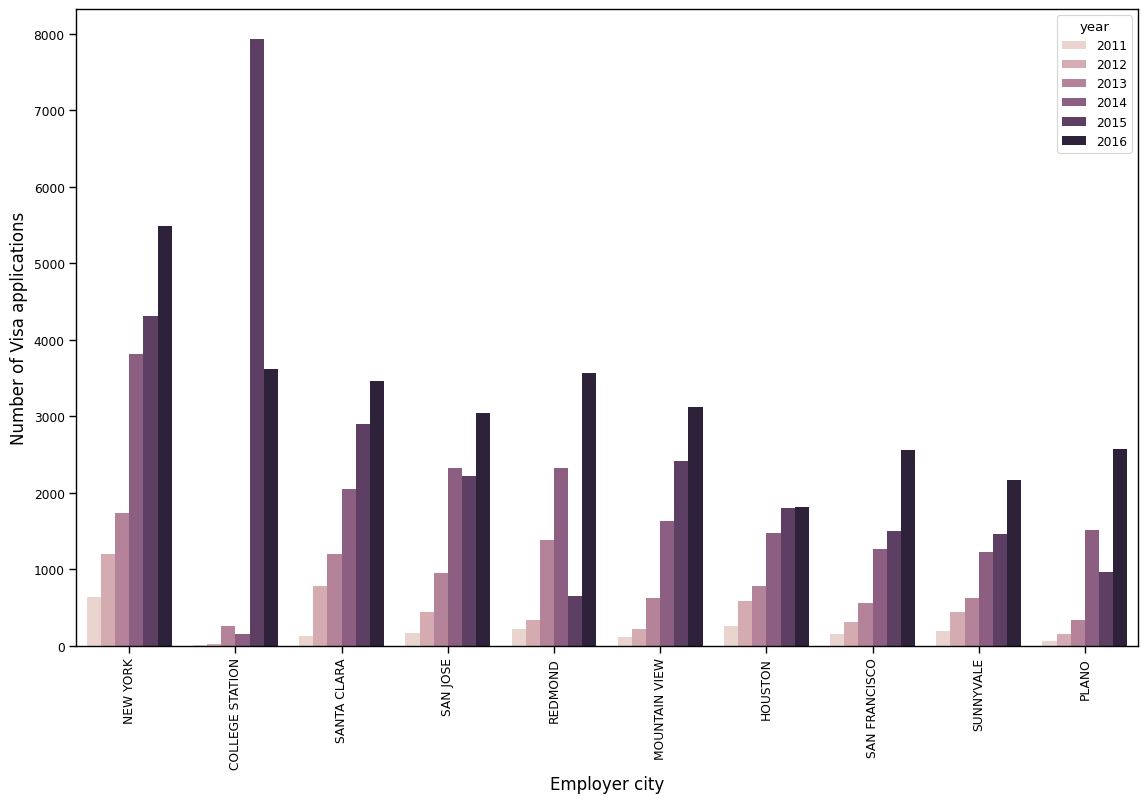

In [31]:
# Creating plot parameters for the cities
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 8.27)
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})
sns.countplot(x='employer_city', hue='year', data=df, order=df.employer_city.value_counts().iloc[:10].index)
plt.xticks(rotation=90)
ax.set(xlabel='Employer city', ylabel='Number of Visa applications')

/tmp/ipykernel_68123/2407200387.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='employer_name', data=df,
/tmp/ipykernel_68123/2407200387.py:9: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x='employer_name', data=df,


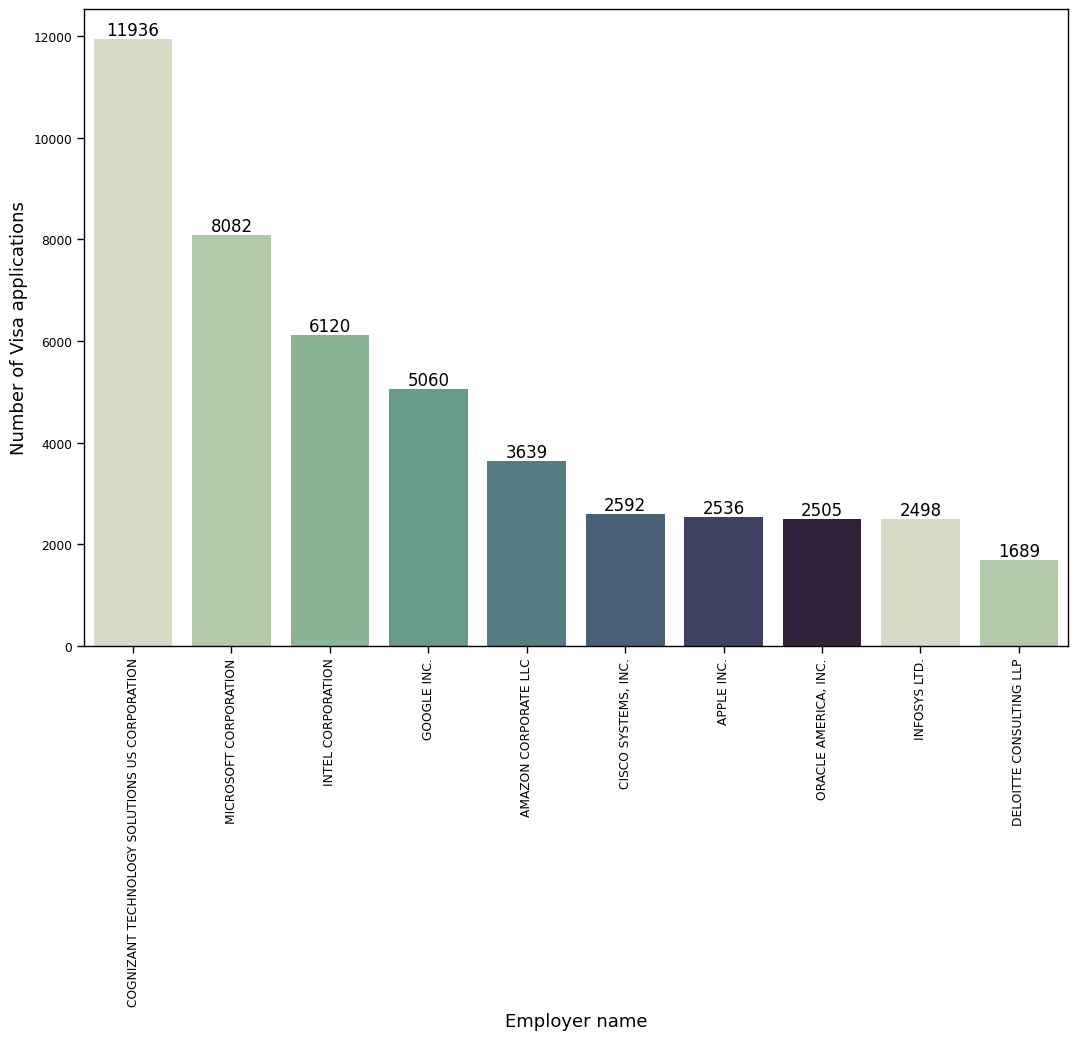

In [35]:
# Create plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)
sns.set_context(rc={"font.size": 12, "axes.labelsize": 13})

# Ensure 'df' contains the dataset
# Ensure 'employer_name' column exists in 'df'
# Create the countplot
sns.countplot(x='employer_name', data=df, 
              palette=sns.cubehelix_palette(8, start=.5, rot=-.75), 
              order=df['employer_name'].value_counts().iloc[:10].index)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Iterate over elements in "employer_name" column and display counts above bars
for i, v in df['employer_name'].value_counts().head(10).items():
    ax.text(i, v, str(v), ha='center', va='bottom')

# Set labels for axes
ax.set(xlabel='Employer name', ylabel='Number of Visa applications')

# Show the plot
plt.show()


In [36]:
#let's take a look at the most desired job titles, citizenships and class of admission of our Visa applicants.

df['job_info_job_title'].value_counts()[:20]

job_info_job_title
Software Engineer                   14372
Computer Systems Analyst - V         4747
Senior Software Engineer             3801
Computer Systems Analyst - II        3416
Software Developer                   2880
Assistant Professor                  2604
Programmer Analyst                   2534
Computer Systems Analyst - IV        2496
Systems Analyst                      2034
Software Development Engineer II     1630
Poultry Processing Worker            1594
Component Design Engineer            1064
Poultry Processor                    1037
Business Analyst                      963
software engineer                     932
SOFTWARE ENGINEER                     877
Senior Programmer Analyst             862
Sr. Software Engineer                 847
Senior Software Developer             817
Commercial Cleaner                    802
Name: count, dtype: int64

In [37]:
#Standardization of casing for letters.
#Splitting job titles by '-'
df['job_info_job_title'] = df['job_info_job_title'].astype(str).str.split('-').str[0]
#Splitting job titles by 'ii'
df['job_info_job_title'] = df['job_info_job_title'].astype(str).str.split('ii').str[0]
#Splitting job titles by '/'
df['job_info_job_title'] = df['job_info_job_title'].astype(str).str.split('/').str[0]
#Removing leading and ending spaces
df['job_info_job_title'] = df['job_info_job_title'].astype(str).str.strip()
#Replacing "sr." values with "senior"
df['job_info_job_title'] = df['job_info_job_title'].str.replace('sr.', 'senior')
#Replacing "NaN", "NaT" and "nan" values with np.nan
df['job_info_job_title'].replace(["NaN", 'NaT','nan'], np.nan, inplace = True)


df['job_info_job_title'].value_counts(dropna=True)[:10]

/tmp/ipykernel_68123/1775668740.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['job_info_job_title'].replace(["NaN", 'NaT','nan'], np.nan, inplace = True)


job_info_job_title
Software Engineer                   15398
Computer Systems Analyst            11937
Senior Software Engineer             4545
Software Developer                   3788
Assistant Professor                  2740
Programmer Analyst                   2733
Systems Analyst                      2146
Software Development Engineer II     1772
Poultry Processing Worker            1594
Business Analyst                     1292
Name: count, dtype: int64

/tmp/ipykernel_68123/86349603.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='job_info_job_title', data=df,


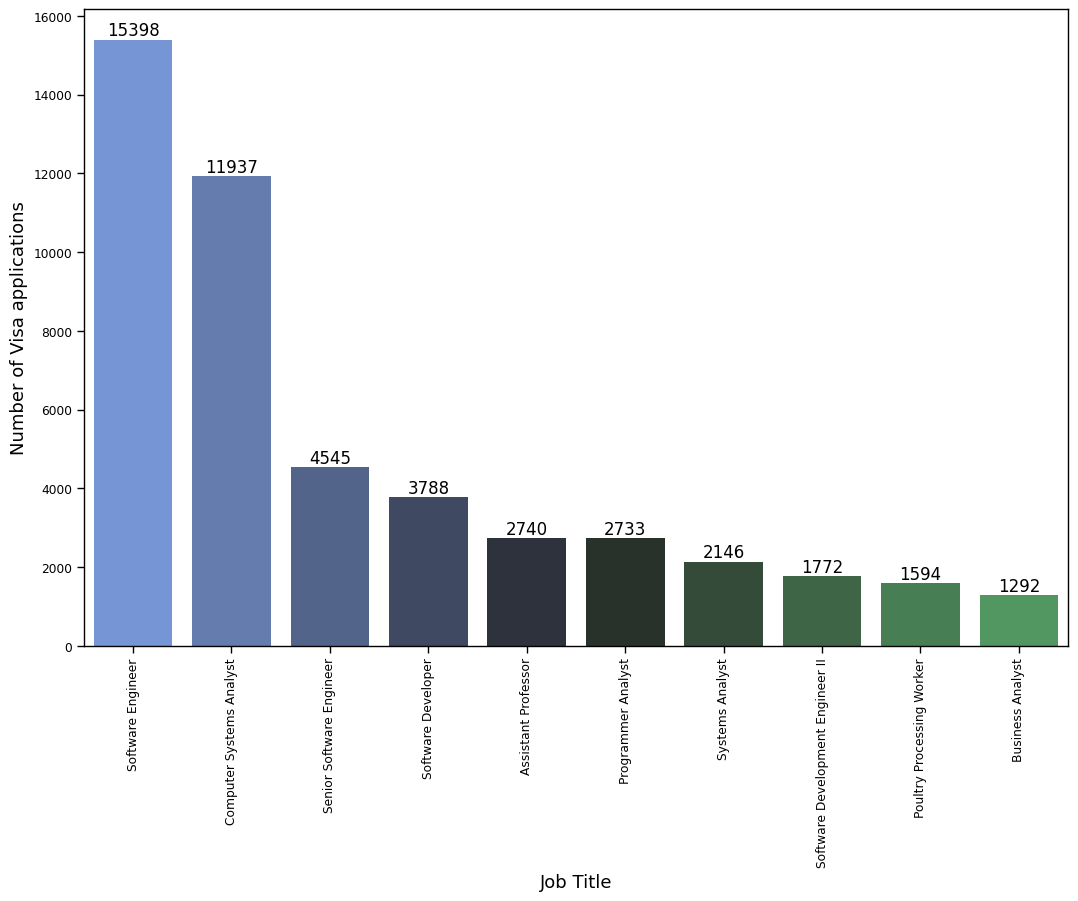

In [39]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)

# Create the countplot
sns.countplot(x='job_info_job_title', data=df, 
              palette=sns.diverging_palette(255, 133, l=60, n=10, center="dark"), 
              order=df['job_info_job_title'].value_counts().iloc[:10].index)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Iterate over elements in "job_info_job_title" column and display counts above bars
for i, v in df['job_info_job_title'].value_counts().head(10).items():
    ax.text(i, v, str(v), ha='center', va='bottom')

# Set labels for axes
ax.set(xlabel='Job Title', ylabel='Number of Visa applications')

# Show the plot
plt.show()


/tmp/ipykernel_68123/472064380.py:7: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.countplot(x='country_of_citizenship', hue='case_status', data=df,


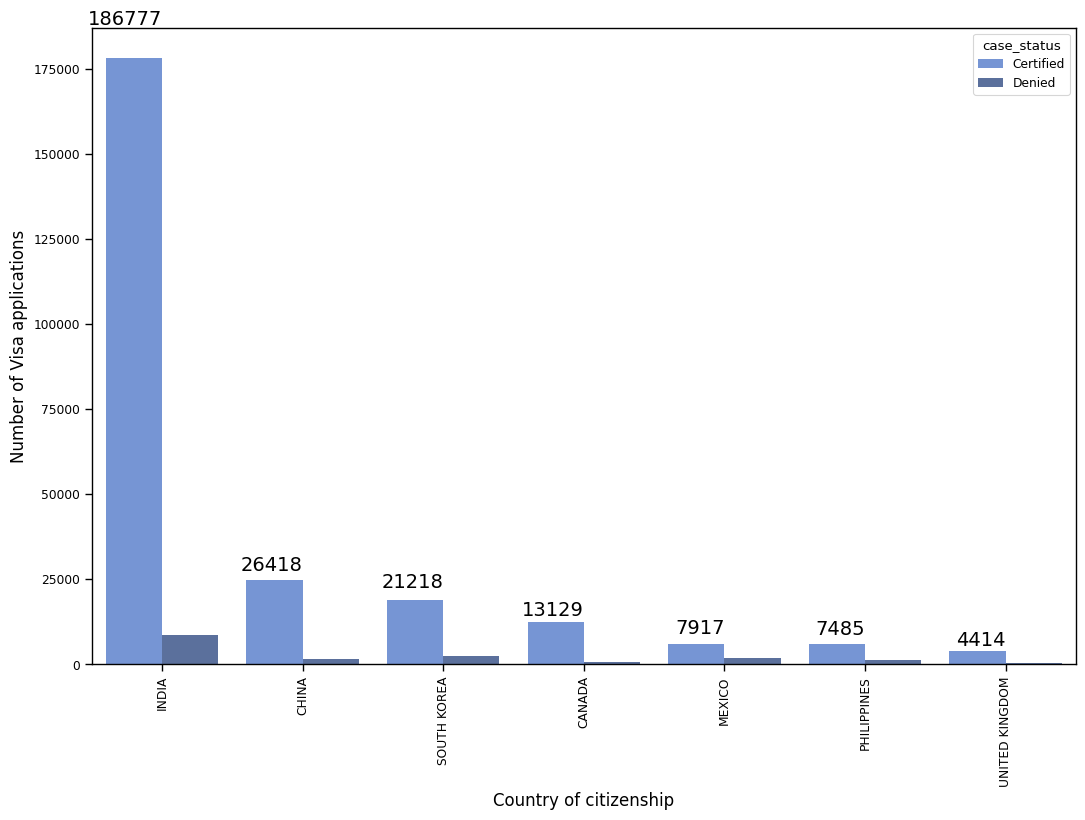

In [41]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)
sns.set_context(rc={"font.size": 14, "axes.labelsize": 12})

# Create the countplot with hue for 'case_status'
sns.countplot(x='country_of_citizenship', hue='case_status', data=df, 
              palette=sns.diverging_palette(255, 133, l=60, n=7, center="dark"), 
              order=df['country_of_citizenship'].value_counts().iloc[:7].index)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Iterate over elements in "country_of_citizenship" column and display counts above bars 
for i, v in df['country_of_citizenship'].value_counts().head(7).items():
    ax.text(i, v, str(v), ha='right', va='bottom')

# Set labels for axes
ax.set(xlabel='Country of citizenship', ylabel='Number of Visa applications')

# Show the plot
plt.show()

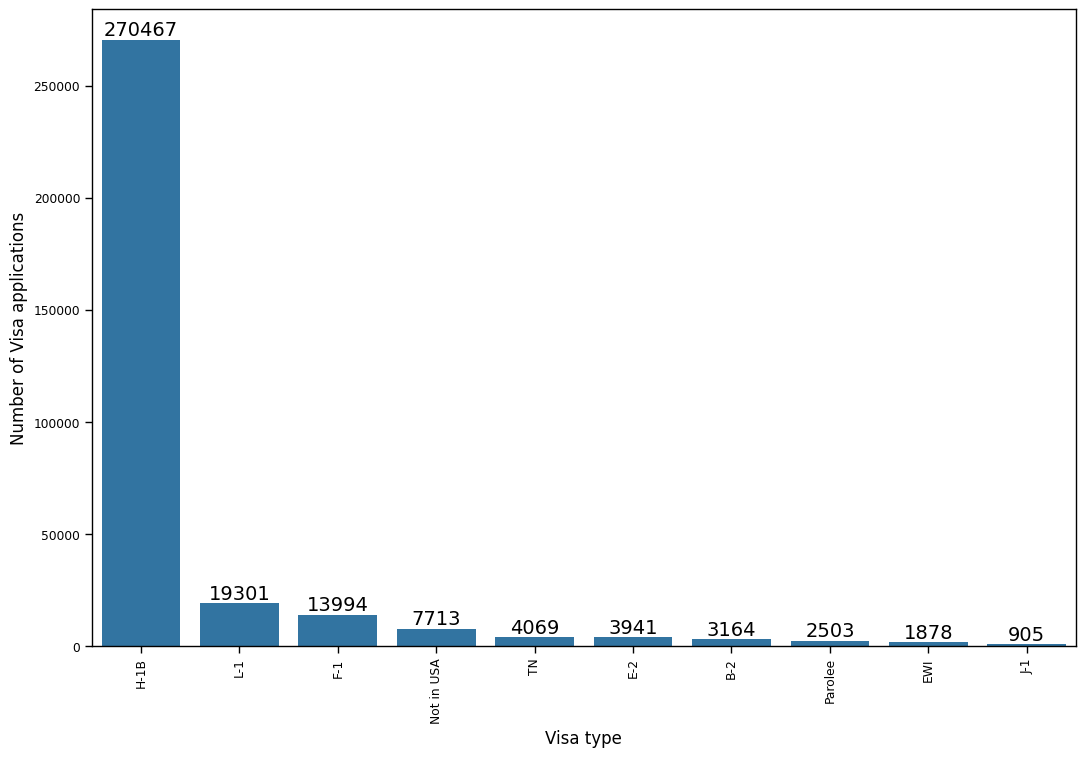

In [44]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)

# Create the countplot
sns.countplot(x='class_of_admission', data=df, 
              order=df['class_of_admission'].value_counts().iloc[:10].index)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Iterate over elements in "class_of_admission" column and display counts above bars 
for i, v in df['class_of_admission'].value_counts().head(10).items():
    ax.text(i, v, str(v), ha='center', va='bottom')

# Set labels for axes
ax.set(xlabel='Visa type', ylabel='Number of Visa applications')

# Show the plot
plt.show()

/tmp/ipykernel_68123/1692960543.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='application_type', data=df, palette=sns.color_palette("GnBu_d"),
/tmp/ipykernel_68123/1692960543.py:6: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(x='application_type', data=df, palette=sns.color_palette("GnBu_d"),


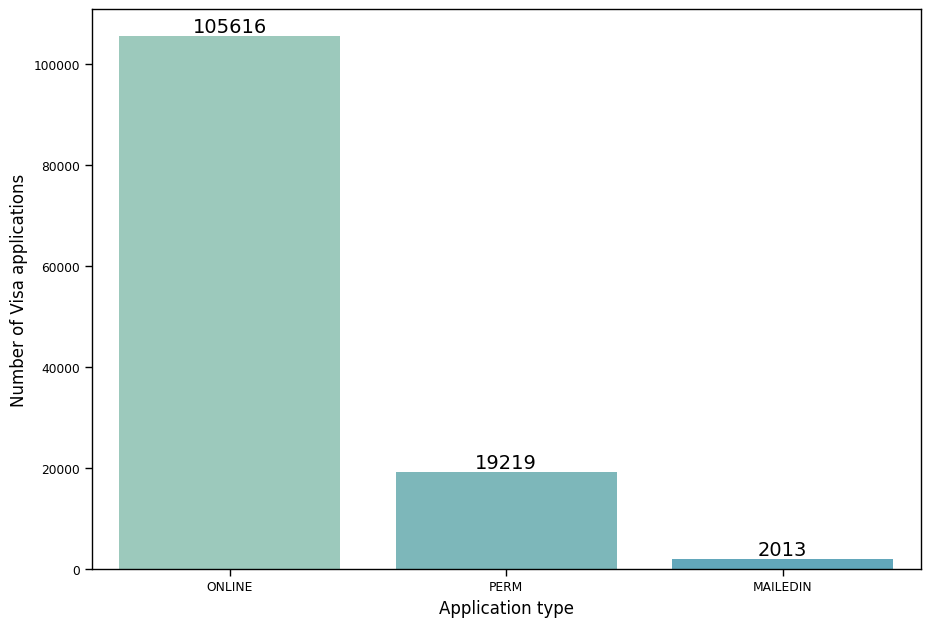

In [45]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 7.27)

# Create the countplot
sns.countplot(x='application_type', data=df, palette=sns.color_palette("GnBu_d"), 
              order=df['application_type'].value_counts().iloc[:10].index)

# Iterate over elements in "application_type" column and display counts above bars 
for i, v in df['application_type'].value_counts().head(10).items():
    ax.text(i, v, str(v), ha='center', va='bottom')

# Set labels for axes
ax.set(xlabel='Application type', ylabel='Number of Visa applications')

# Show the plot
plt.show()


/tmp/ipykernel_68123/1698612970.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='foreign_worker_info_education', data=df,
/tmp/ipykernel_68123/1698612970.py:6: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.countplot(x='foreign_worker_info_education', data=df,


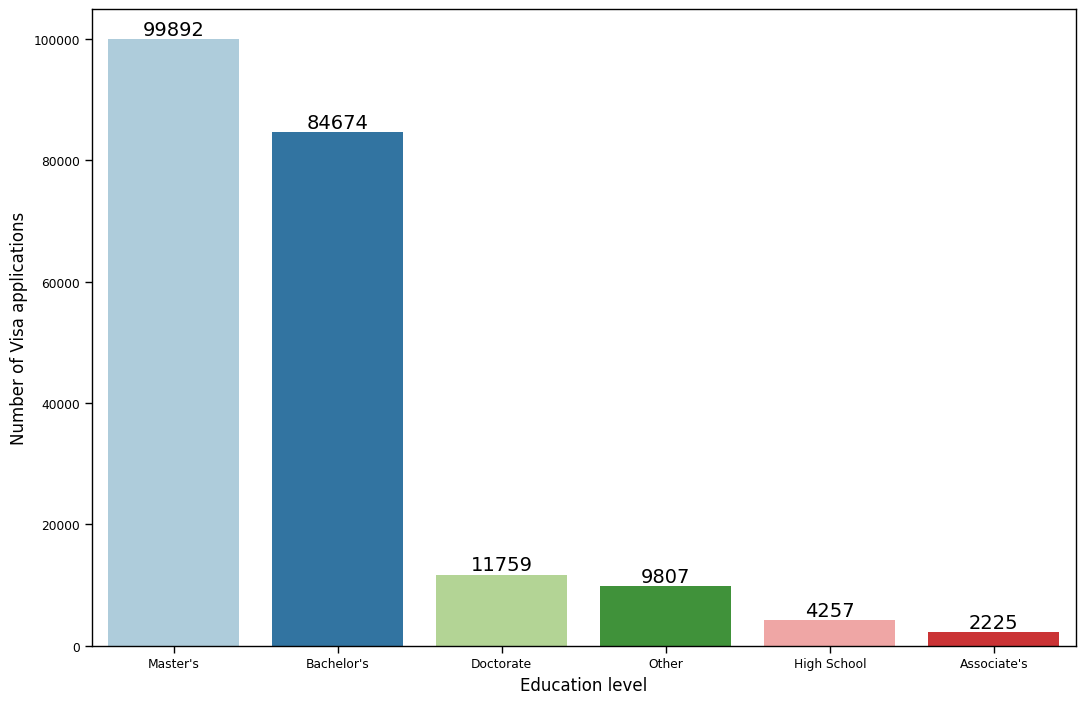

In [46]:
# Setting plot parameters
fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)

# Create the countplot
sns.countplot(x='foreign_worker_info_education', data=df, 
              palette=sns.color_palette("Paired"), 
              order=df['foreign_worker_info_education'].value_counts().iloc[:10].index)

# Iterate over elements in "foreign_worker_info_education" column and display counts above bars 
for i, v in df['foreign_worker_info_education'].value_counts().head(10).items():
    ax.text(i, v, str(v), ha='center', va='bottom')

# Set labels for axes
ax.set(xlabel='Education level', ylabel='Number of Visa applications')

# Show the plot
plt.show()

In [47]:
#Displaying some payment amounts
df[['pw_amount_9089','pw_unit_of_pay_9089']].head(10)

,pw_amount_9089,pw_unit_of_pay_9089
0,75629.0,yr
1,37024.0,yr
2,47923.0,yr
3,10.97,hr
4,94890.0,yr
5,37024.0,yr
6,47083.33,yr
7,36733.0,yr
8,44824.0,yr
9,12.86,hr


In [51]:
#Replacing commas with whitespace character
df['pw_amount_9089'] = df['pw_amount_9089'].str.replace(",","") 

for unit in df.pw_unit_of_pay_9089.unique():
    if unit == "hr" or unit == "Hour":
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_amount_9089'] = df['pw_amount_9089'].apply(lambda x: float(x) * 8 * 250)
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_unit_of_pay_9089'] = df['pw_unit_of_pay_9089'].replace(to_replace = unit, value = "Year") 
    elif unit == "wk" or unit == "Week":
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_amount_9089'] = df['pw_amount_9089'].apply(lambda x: float(x) * 50)
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_unit_of_pay_9089'] = df['pw_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    elif unit == "mth" or unit == "Month":
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_amount_9089'] = df['pw_amount_9089'].apply(lambda x: float(x) * 12)
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_unit_of_pay_9089'] = df['pw_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    elif unit == "bi" or unit == "Bi-Weekly":  
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_amount_9089'] = df['pw_amount_9089'].apply(lambda x: float(x) * 25)
        df.loc[df['pw_unit_of_pay_9089'] == unit, 'pw_unit_of_pay_9089'] = df['pw_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    elif unit =="yr":
         df.loc[df['pw_unit_of_pay_9089'] == unit ,'pw_unit_of_pay_9089'] = df['pw_unit_of_pay_9089'].replace(to_replace = unit, value = "Year")
    else:
        continue
        
#Filling missing values with median 
df['pw_amount_9089']= df['pw_amount_9089'].fillna((df['pw_amount_9089'].median()))

#Changing format from string to float
df['pw_amount_9089'] = df.pw_amount_9089.astype(float)

#Displaying 10 first values
df[['pw_amount_9089','pw_unit_of_pay_9089']].head(10)

TypeError: Cannot convert ['75629.0' '37024.0' '47923.0' ... '114795.00' '112354.00' '136219.00'] to numeric